In [1]:
from __future__ import absolute_import, division, print_function

import random
import pathlib
import tensorflow as tf
import IPython.display as display

tf.enable_eager_execution()
tf.VERSION

'1.14.1-dev20190313'

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

/home/maksym/.keras/datasets/flower_photos


In [5]:
for item in data_root.iterdir():
  print(item)

/home/maksym/.keras/datasets/flower_photos/dandelion
/home/maksym/.keras/datasets/flower_photos/roses
/home/maksym/.keras/datasets/flower_photos/LICENSE.txt
/home/maksym/.keras/datasets/flower_photos/sunflowers
/home/maksym/.keras/datasets/flower_photos/tulips
/home/maksym/.keras/datasets/flower_photos/daisy


In [6]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [7]:
all_image_paths[:10]

['/home/maksym/.keras/datasets/flower_photos/dandelion/151385302_f8980a257f_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/3662701865_3ff283a33a_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/14022473102_3b24ca08cb_m.jpg',
 '/home/maksym/.keras/datasets/flower_photos/sunflowers/7270375648_79f0caef42_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/17080000869_a80e767f4a_m.jpg',
 '/home/maksym/.keras/datasets/flower_photos/roses/8692051081_dffa8709e7_m.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/2521811279_1f7fc353bf_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/sunflowers/1240624822_4111dde542.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/16159487_3a6615a565_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/roses/4061451210_1650590c6a.jpg']

In [8]:
attributions = (data_root/"LICENSE.txt").read_text(encoding="utf8").splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [9]:
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [10]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [11]:
label_to_index = dict((name, index) for index, name  in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [12]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels in indices: ", all_image_labels[:10])

First 10 labels in indices:  [1, 1, 4, 3, 1, 2, 1, 3, 1, 2]


In [13]:
img_path = all_image_paths[0]
img_path

'/home/maksym/.keras/datasets/flower_photos/dandelion/151385302_f8980a257f_n.jpg'

In [14]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+'...')

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [15]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 320, 3)
<dtype: 'uint8'>


In [16]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [17]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0
    
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

Text(0.5, 1.0, 'Daisy')

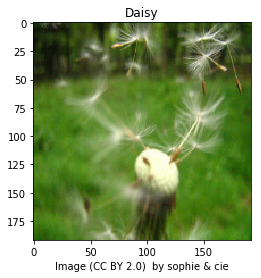

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

image_path = all_image_paths[10]
label = all_image_labels[10]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())

In [19]:
# Build a tf.data.Dataset

In [20]:
print(all_image_paths[:10])
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

['/home/maksym/.keras/datasets/flower_photos/dandelion/151385302_f8980a257f_n.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/3662701865_3ff283a33a_n.jpg', '/home/maksym/.keras/datasets/flower_photos/tulips/14022473102_3b24ca08cb_m.jpg', '/home/maksym/.keras/datasets/flower_photos/sunflowers/7270375648_79f0caef42_n.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/17080000869_a80e767f4a_m.jpg', '/home/maksym/.keras/datasets/flower_photos/roses/8692051081_dffa8709e7_m.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/2521811279_1f7fc353bf_n.jpg', '/home/maksym/.keras/datasets/flower_photos/sunflowers/1240624822_4111dde542.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/16159487_3a6615a565_n.jpg', '/home/maksym/.keras/datasets/flower_photos/roses/4061451210_1650590c6a.jpg']


In [21]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ',repr(path_ds.output_types))
print()
print(path_ds)

shape:  TensorShape([])
type:  tf.string

<DatasetV1Adapter shapes: (), types: tf.string>


In [22]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

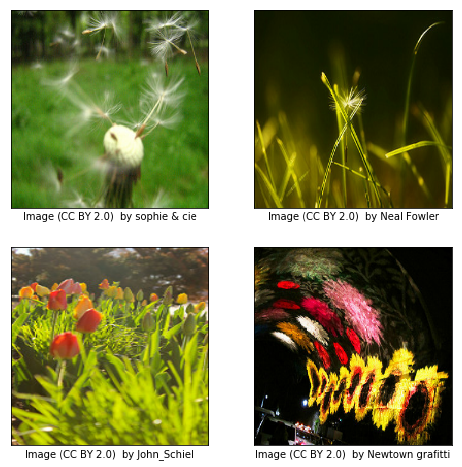

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

In [24]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [25]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

dandelion
dandelion
tulips
sunflowers
dandelion
roses
dandelion
sunflowers
dandelion
roses


In [26]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [27]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (192, 192, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [28]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [29]:
BATCH_SIZE = 32
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [30]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)

W0320 10:07:05.265738 139837415679808 deprecation.py:323] From <ipython-input-30-26ec577327e3>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [31]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

In [32]:
help(tf.keras.applications.mobilenet_v2.preprocess_input)

Help on function wrapper in module tensorflow.python.keras.applications:

wrapper(*args, **kwargs)



In [33]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [34]:
image_batch, label_batch = next(iter(keras_ds))

In [35]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [36]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [37]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -2.6907997
max logit: 3.44976

Shape: (32, 5)


In [38]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [39]:
len(model.trainable_variables) 

2

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [43]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 40s 13s/step - loss: 5.9236 - acc: 0.3854
